In [2]:
library(MASS)
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



## A freind of mine works a lot with regression, but only uses OLS and doesn't know about ridge or lasso regularization. I volunteered to take a look and see what kind of results I found. This freind also only uses single variable regression, so I also wanted to investigate the performance of a multivariate model.

In [3]:
actual <- log(c(462013,8490,162011,35710,404995,236036,263045,25134,310185,128922,5420,1587600))

# our available variables
a <- c(99578,0.001,270690,48329,490944,0.001,882665,0.001,0.001,0.001,0.001,1844303)
b <- c(860403,4604,145154,51082,186943,108519,170585,18413,913413,186539,16230,2095601)
c <- c(92723,17993,112082,14738,94995,309410,132025,1712,113215,11581,9743,603188)

df <- as.data.frame(cbind(log(a),log(b),log(c)))
mat <- model.matrix(actual~.,data = df)[,-1]

# training-testing split
trainRows <- sample(1:nrow(mat),(nrow(mat)/2))
testRows <- (-trainRows)
actualTest  <- actual[testRows]

In [4]:
print("training")
print(cbind(df[trainRows,],actual[trainRows]))
print('testing')
print(cbind(df[testRows,],actual[testRows]))


[1] "training"
          V1        V2        V3 actual[trainRows]
6  -6.907755 11.594681 12.642423         12.371740
5  13.104085 12.138559 11.461580         12.911630
4  10.785787 10.841187  9.598184         10.483186
2  -6.907755  8.434681  9.797738          9.046644
10 -6.907755 12.136396  9.357121         11.766963
3  12.508730 11.885551 11.626986         11.995420
[1] "testing"
          V1        V2        V3 actual[testRows]
1  11.508697 13.665156 11.437372        13.043348
7  13.690701 12.046989 11.790747        12.480080
8  -6.907755  9.820812  7.445418        10.131977
9  -6.907755 13.724943 11.637044        12.644924
11 -6.907755  9.694617  9.184304         8.597851
12 14.427612 14.555351 13.309984        14.277734


## Construct Models 

In [5]:
lambdas  <- 10^seq(10,-2,length=100)
train.ridge <- glmnet(mat[trainRows,],actual[trainRows],alpha = 0,lambda = lambdas)


## OLS Predictions

In [6]:
train.ols <- lm(actual~.,data=df,subset = trainRows)
predictions.ols <- predict(train.ols,newx = df[testRows,])

## Ridge Predictions

In [7]:
train.ridge <- glmnet(mat[trainRows,],actual[trainRows],alpha = 0,lambda = lambdas)
predictions.ridge <- predict(train.ridge,s=best.lambda,newx = mat[testRows,])

ERROR: Error in predict.glmnet(train.ridge, s = best.lambda, newx = mat[testRows, : object 'best.lambda' not found


## Lasso Predictions

In [8]:
train.lasso <- glmnet(mat[trainRows,],actual[trainRows],alpha = 1,lambda = lambdas)
#find best lambda
best.lambda <- cv.glmnet(mat[trainRows,],actual[trainRows],alpha=0)$lambda.min
predictions.lasso <- predict(train.lasso,s=best.lambda,newx = mat[testRows,])

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”

## Compare Predictions

In [9]:
mse.ols  <- mean((predictions.ols - actual[testRows])^2)
mse.ridge  <- mean((predictions.ridge - actual[testRows])^2)
mse.lasso  <- mean((predictions.lasso - actual[testRows])^2)

print('OLS MSE')
print(mse.ols)
print('Ridge MSE')
print(mse.ridge)
print('Lasso MSE')
print(mse.lasso)

ERROR: Error in mean((predictions.ridge - actual[testRows])^2): object 'predictions.ridge' not found


## Compare Stability

In [10]:
ols.mse  <- list()
ridge.mse  <- list()
lasso.mse  <- list()

for(i in 1:1000){
    actual <- log(c(462013,8490,162011,35710,404995,236036,263045,25134,310185,128922,5420,1587600))

    a <- c(99578,0.0001,270690,48329,490944,0.001,882665,0.0001,0.0001,0.0001,0.0001,1844303)
    b <- c(860403,4604,145154,51082,186943,108519,170585,18413,913413,186539,16230,2095601)
    c <- c(92723,17993,112082,14738,94995,309410,132025,1712,113215,11581,9743,603188)

    df <- as.data.frame(cbind(log(a),log(b),log(c)))
    mat <- model.matrix(actual~.,data = df)[,-1]
    
    

    #segments
    trainRows <- sample(1:nrow(mat),(nrow(mat)/2))
    testRows <- (-trainRows)
    actualTest  <- actual[testRows]
    
    train.ols <- lm(actual~.,data=df,subset = trainRows)
    predictions.ols <- predict(train.ols,newx = df[testRows,])
    
    train.ridge <- glmnet(mat[trainRows,],actual[trainRows],alpha = 0,lambda = lambdas)
    best.lambda <- cv.glmnet(mat[trainRows,],grouped=FALSE,actual[trainRows],alpha=0)$lambda.min
    predictions.ridge <- predict(train.ridge,s=best.lambda,newx = mat[testRows,])
    
    train.lasso <- glmnet(mat[trainRows,],actual[trainRows],alpha = 1,lambda = lambdas)
    predictions.lasso <- predict(train.lasso,s=best.lambda,newx = mat[testRows,])
    ols.mse[i]   <- mean((predictions.ols - actual[testRows])^2)
    ridge.mse[i] <- mean((predictions.ridge - actual[testRows])^2)
    lasso.mse[i] <- mean((predictions.lasso - actual[testRows])^2)
}


In [17]:
print(max(as.numeric(ridge.mse)))

[1] 66.35884


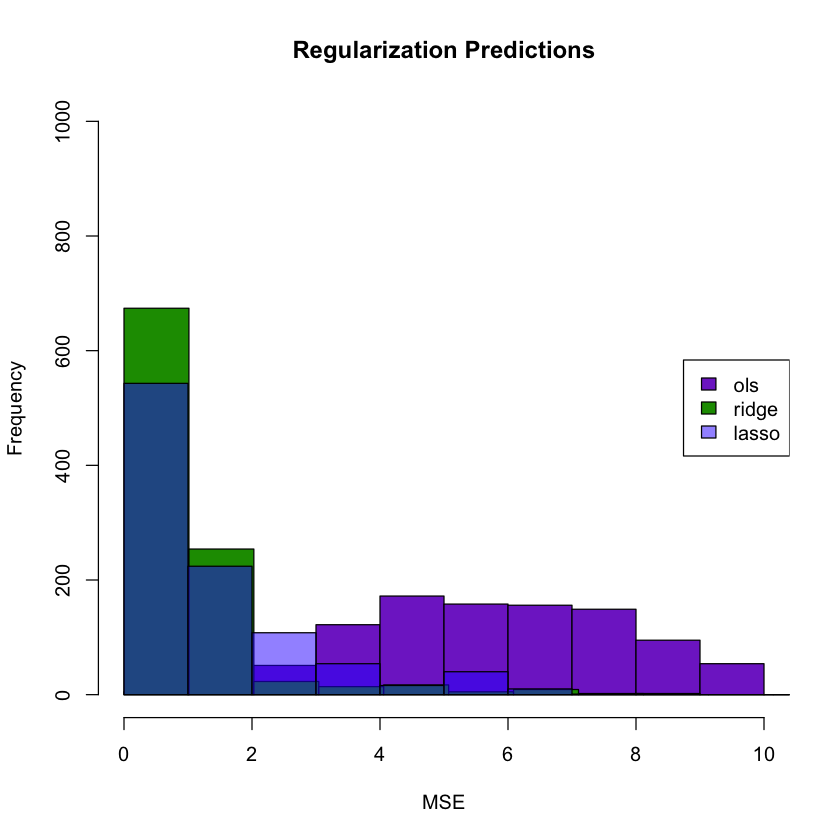

In [32]:
# Histogram Grey Color
hist(as.numeric(ols.mse),ylim=c(0,1000),breaks = seq(from=0,to=20,by=1), col=rgb(0.5,0.2,0.8,1),add=F, xlim = c(0,10),main = "Regularization Predictions",xlab = "MSE")
hist(as.numeric(ridge.mse), breaks = seq(from=0,to=70, length.out = 70),col=rgb(0.1,0.6,0,1),add=T, xlim = c(0,10))
hist(as.numeric(lasso.mse), breaks = seq(from=0,to=20,by=1),col=rgb(0.2,0.1,1,0.5),add=T, xlim = c(0,10))
legend('right',c('ols','ridge','lasso'),fill = c(rgb(0.5,0.2,0.8,1),rgb(0.1,0.6,0,1),rgb(0.2,0.1,1,0.5)))


# Ridge/Lasso Assumptions

### Linearity of dependent variable with independant variables

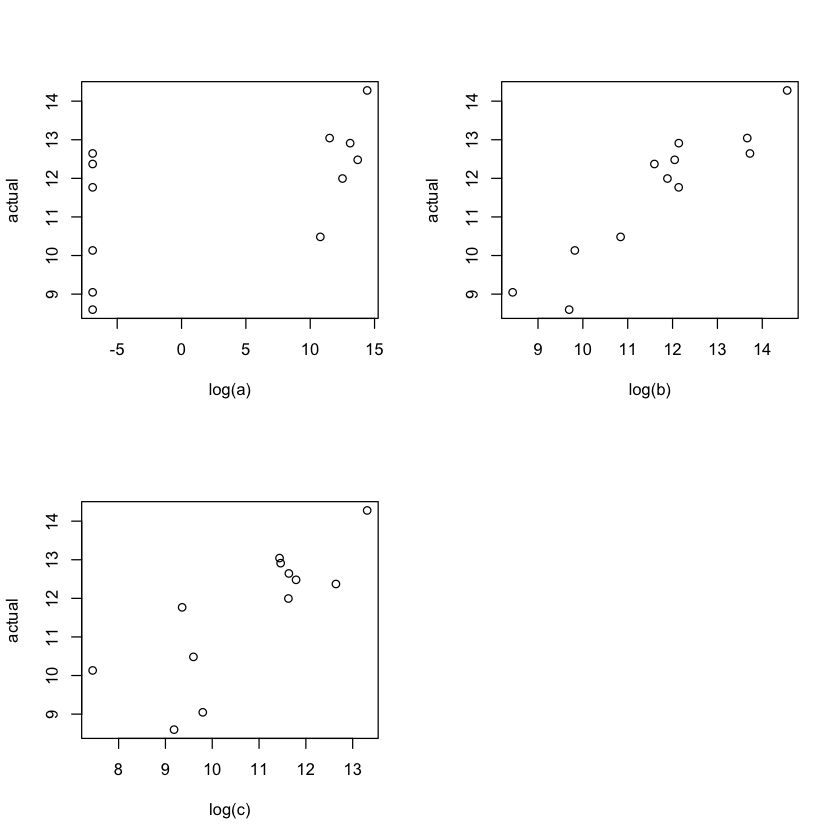

In [118]:
par(mfrow = c(2,2))
plot(log(a),actual)
plot(log(b),actual)
plot(log(c),actual)

### I'd say that variable 'a' is a little be questionable, but 'b' and 'c' seem fine

In [120]:
install.packages("Hmisc")

also installing the dependencies ‘checkmate’, ‘latticeExtra’, ‘acepack’, ‘gridExtra’, ‘htmlTable’, ‘viridis’




The downloaded binary packages are in
	/var/folders/m5/h_876gpd4ml06hs93nnx08nc0000gn/T//RtmprlrzAY/downloaded_packages


### No terribly collinear predictor variables

In [121]:
library("Hmisc")
res2 <- rcorr(mat)
res2

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units



     V1   V2   V3
V1 1.00 0.49 0.51
V2 0.49 1.00 0.72
V3 0.51 0.72 1.00

n= 12 


P
   V1     V2     V3    
V1        0.1038 0.0917
V2 0.1038        0.0087
V3 0.0917 0.0087       

In [126]:
vif(glm(actual~log(a)+log(b)+log(c)))

log(a)   log(b)   log(c) 
1.412545 2.155443 2.200707

### Usually a variance inflation factor of 5 or more is considered bad. These appear to be ok.

Now I want to compare ridge with the model that my freind was currently using. Their model was this
\begin{aligned}
\hat{y}&= \log{(a)} +\log{(b)}+\log{(c)}
\end{aligned}